In [101]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras.models import Model

# Network

# Encoder
input_img = Input(shape = (28, 28, 1))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) # 14 x 14 x 32
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) # 7 x 7 x 64
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128
flat = Flatten()(conv3) # 6272
fc1 = Dense(784)(flat)
encoded = Dense(28)(fc1)
encoder = Model(input_img, encoded)

# Decoder
input_encoded = Input(shape=(28,))
fc2 = Dense(784)(input_encoded)
fc3 = Dense(6272)(fc2)
unflat = Reshape((7, 7, 128))(fc3)
conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(unflat) #7 x 7 x 128
up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
decoder = Model(input_encoded, decoded)

# Full model
autoencoder = Model(input_img, decoder(encoded))
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
flatten_14 (Flatten)         (None, 6272)              0         
__________

In [102]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [103]:
history = autoencoder.fit(x_train, x_train,
                          epochs=10,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 20s 331us/step - loss: 0.2369 - val_loss: 0.1566
Epoch 2/10
60000/60000 [==============================] - 18s 302us/step - loss: 0.1382 - val_loss: 0.1167
Epoch 3/10
60000/60000 [==============================] - 18s 302us/step - loss: 0.1147 - val_loss: 0.1055
Epoch 4/10
60000/60000 [==============================] - 18s 301us/step - loss: 0.1047 - val_loss: 0.1020
Epoch 5/10
60000/60000 [==============================] - 18s 303us/step - loss: 0.0987 - val_loss: 0.0953
Epoch 6/10
60000/60000 [==============================] - 18s 302us/step - loss: 0.0940 - val_loss: 0.0902
Epoch 7/10
60000/60000 [==============================] - 18s 301us/step - loss: 0.0906 - val_loss: 0.0905
Epoch 8/10
60000/60000 [==============================] - 18s 301us/step - loss: 0.0881 - val_loss: 0.0845
Epoch 9/10
60000/60000 [==============================] - 18s 301us/step - loss: 0.0863 - val_

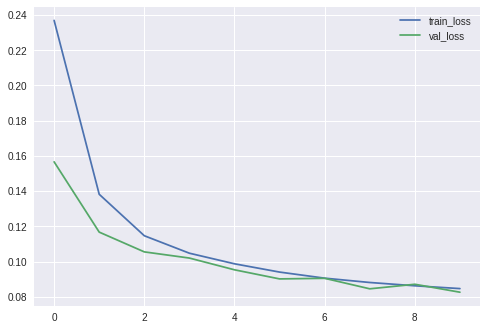

In [108]:
# Plot loss
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss)
plt.plot(val_loss)
plt.gca().legend(('train_loss','val_loss'))

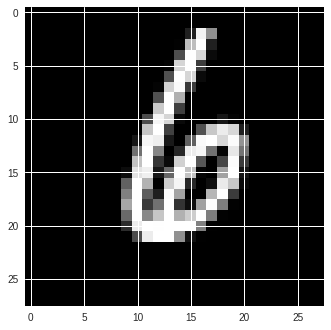

In [109]:
# Visualize Random Image
rand_img = x_test[np.random.randint(len(x_test))]
plt.imshow(rand_img[:, :, 0], cmap='gray')

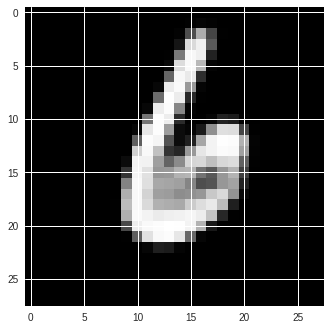

In [110]:
# Run it through encoder
rand_decoded = autoencoder.predict(np.expand_dims(rand_img, axis=0))
plt.imshow(rand_decoded[0][:, :, 0], cmap='gray')

In [111]:
# Look at encoded vector

rand_encoding = encoder.predict(np.expand_dims(rand_img, axis=0))
print(rand_encoding[0])

[-2.5692544   0.96198654 -2.0642452  -2.1632867   3.76463    -0.45528185
  0.42421895 -1.1607599  -2.501239    1.0214423  -0.7471696  -1.2251018
  4.086884    1.2166333  -0.3988942   0.2755425   0.5403377  -2.0122595
 -2.1075635   2.3291962  -0.7656926  -0.9719486  -2.598697   -1.0272634
  1.0383956   3.1247644  -1.9663988  -1.0008905 ]


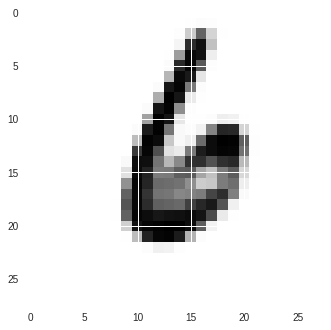

In [112]:
# Run encoded vector through decoder

rand_decoding = decoder.predict(rand_encoding)
plt.imshow(rand_decoding[0][:,:,0])

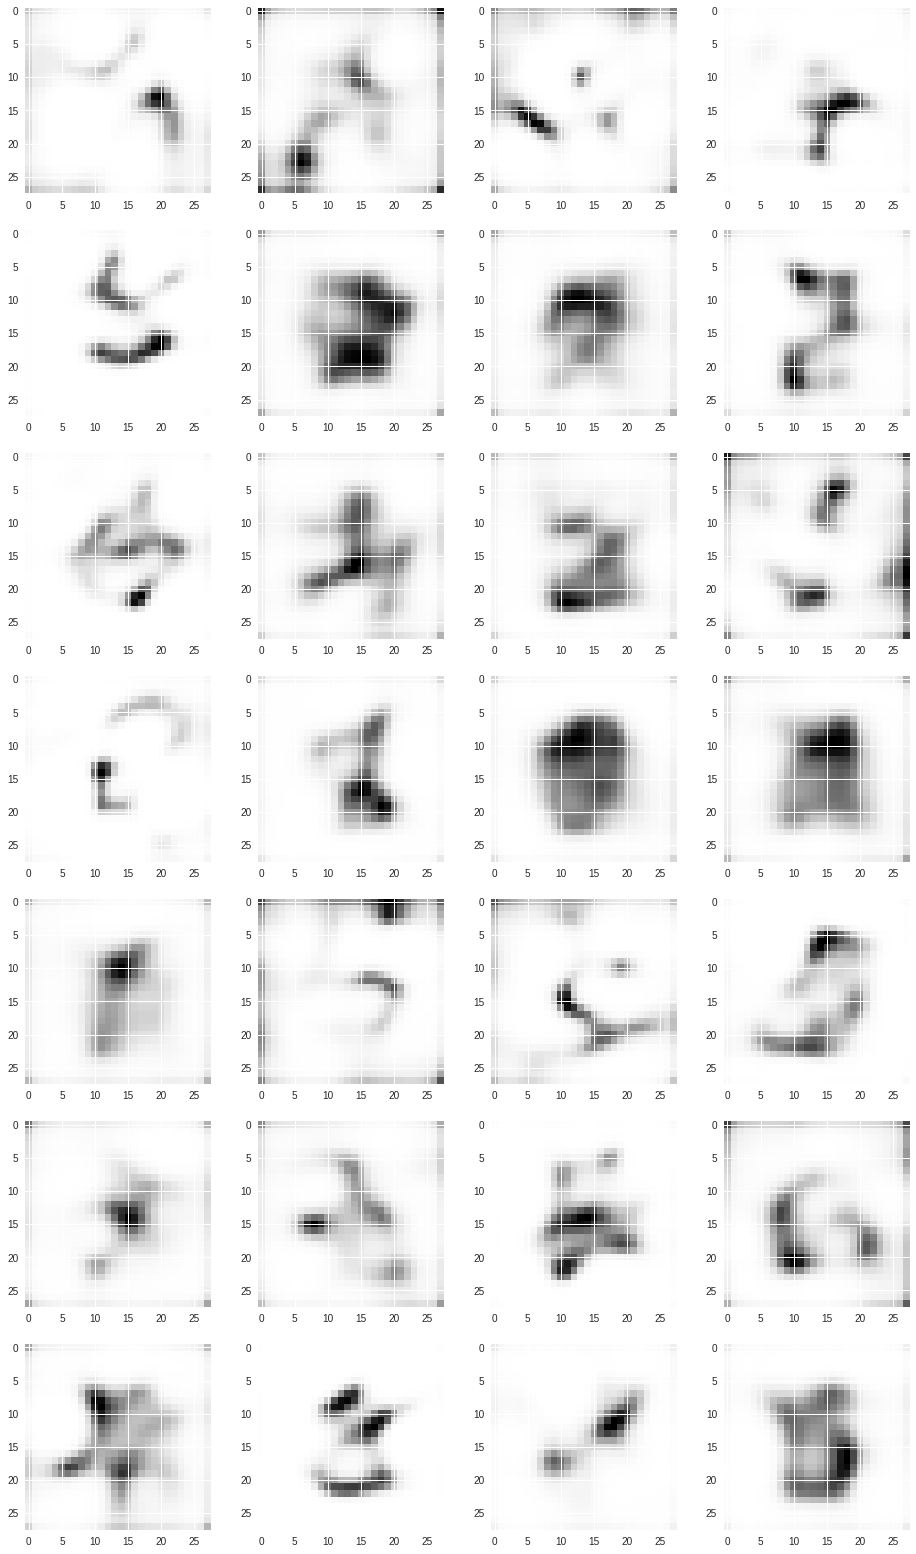

In [131]:
# Zero out pixels one by one and display the outputs

fig = plt.figure()

for i in range(28):
  
  # Get output
  mask = np.zeros(28)
  mask[i] = 1 # make a single value non-zero
  masked = np.multiply(rand_encoding, mask)
  decoded_masked = decoder.predict(masked)
  
  # Plot
  fig.add_subplot(7, 4, i + 1)
  plt.imshow(decoded_masked[0][:,:,0])

fig.set_size_inches(16, 28)